In [1]:
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

/home/balakrishnan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Get data

In [3]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination='pizza_steak_sushi'
)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## Datasets and DataLoaders

In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(manual_transforms)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fae1047fee0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

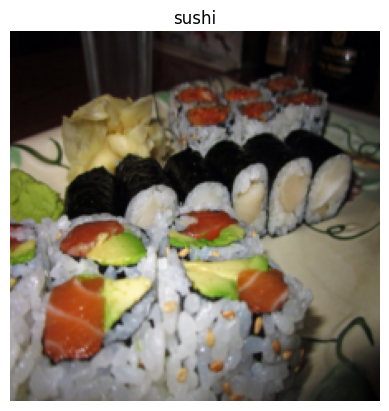

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

## Working on the architecture

### Patch embeddings

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width)/patch_size**2)
print(height, width, patch_size, number_of_patches)

224 224 16 196


In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

(-0.5, 223.5, 223.5, -0.5)

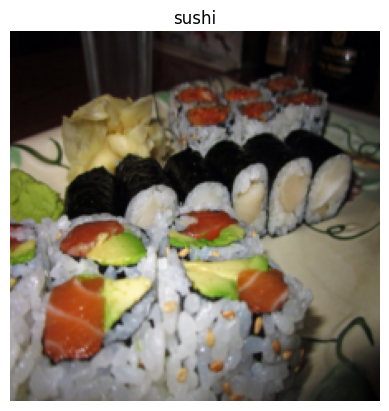

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

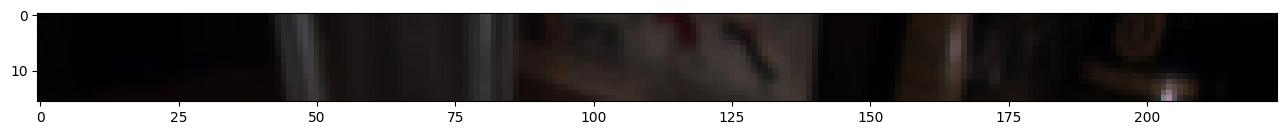

In [12]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

14.0 16


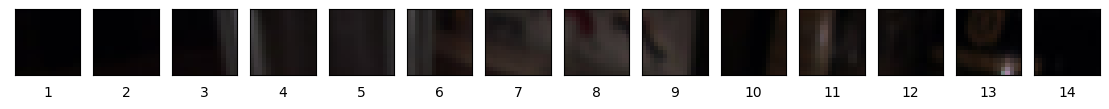

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(num_patches, patch_size)

fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

14.0


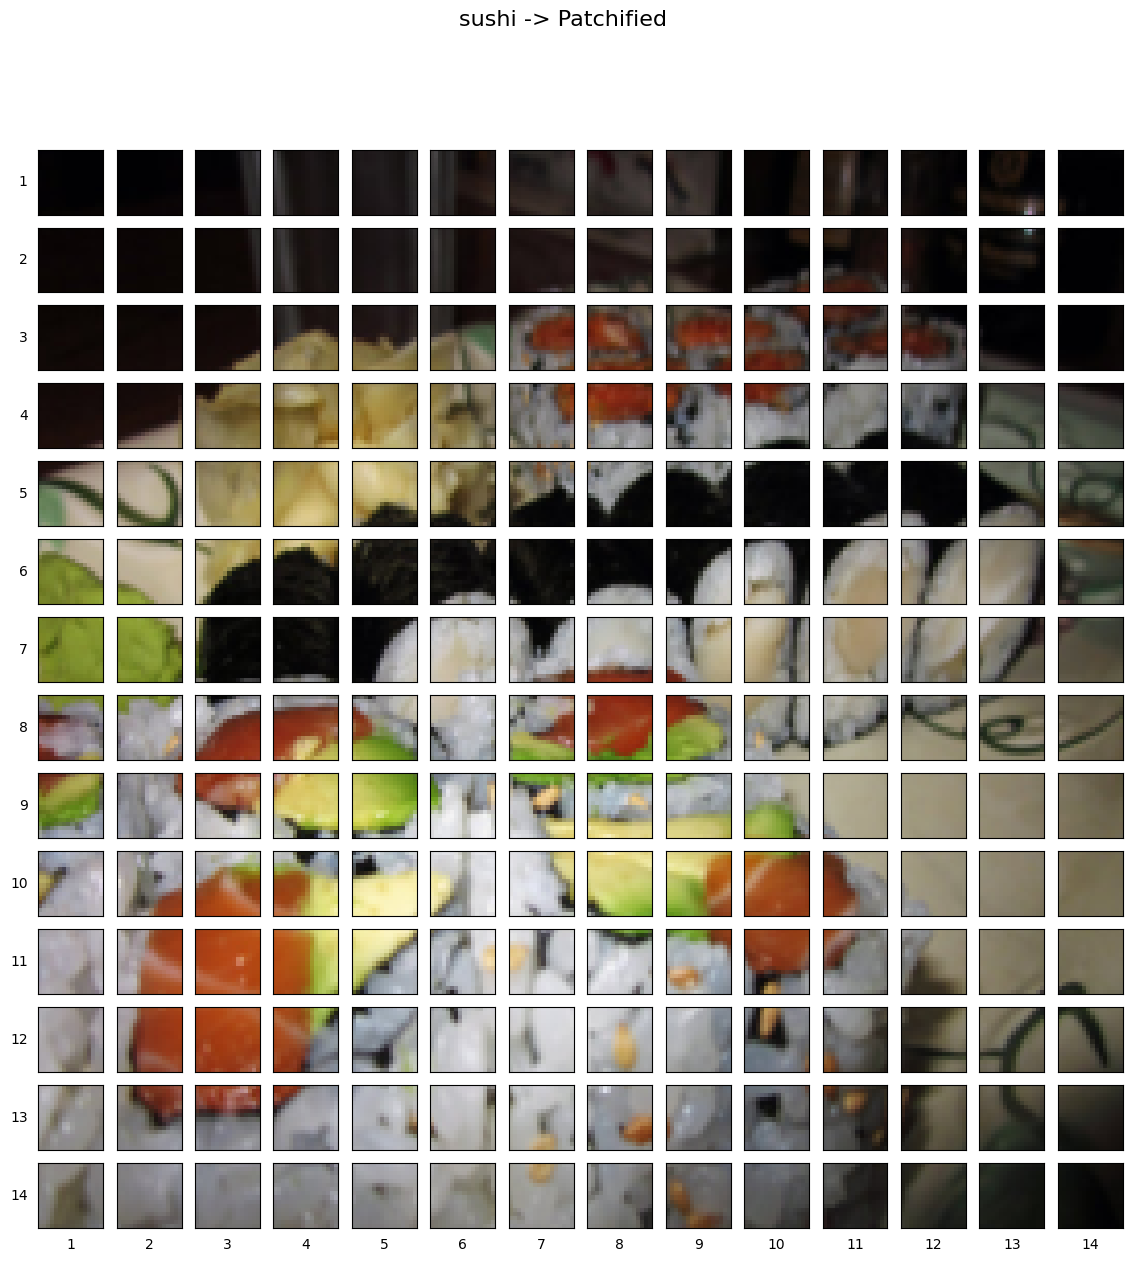

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(num_patches)

fig, axs = plt.subplots(
    nrows=int(num_patches),
    ncols=int(num_patches),
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(image_permuted[
            patch_height:patch_height+patch_size,
            patch_width:patch_width+patch_size,
            :
        ])
        axs[i][j].set_ylabel(
            i+1,
            rotation='horizontal',
            horizontalalignment='right',
            verticalalignment='center'
        )
        axs[i][j].set_xlabel(j+1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()
fig.suptitle(f'{class_names[label]} -> Patchified', fontsize=16)
plt.show()

In [15]:
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

(-0.5, 223.5, 223.5, -0.5)

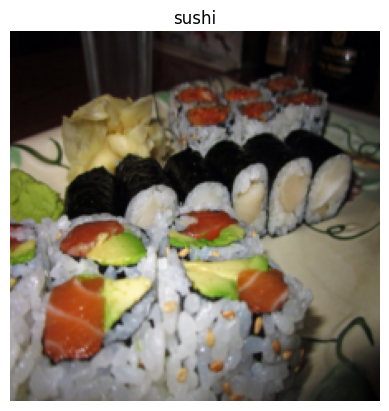

In [16]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [17]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


[565, 133, 222, 517, 385]


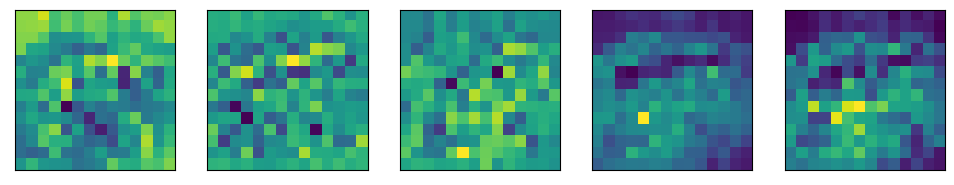

In [18]:
import random
random_indices = random.sample(range(0, 768), k=5)
print(random_indices)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indices):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
print(
    'Current tensor shape:',
    image_out_of_conv.shape,
    '-> [batch, embedding_dim, feature_map_height, feature_map_width'
)

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width


In [20]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])


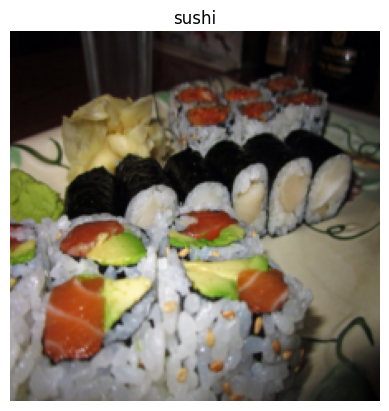

In [21]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(image.shape)

image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(image_out_of_conv_flattened.shape)

In [22]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(
    'Patch embedding sequence shape:',
    image_out_of_conv_flattened_reshaped.shape,
    '-> [batch_size, num_patches, embedding_size]'
)

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

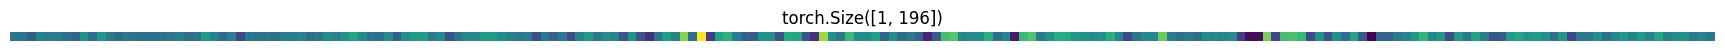

In [23]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(single_flattened_feature_map.shape)
plt.axis(False)

In [24]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. 
            Defaults to 3.
        patch_size (int): Size of patches to convert input image into.
            Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into.
            Defaults to 768.
    """
    def __init__(
        self,
        in_channels: int = 3,
        patch_size : int = 16,
        embedding_dim : int = 768
    ) -> None:
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [25]:
set_seeds()

patchify = PatchEmbedding()
print(image.unsqueeze(0).shape)
patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [26]:
random_input_image = (1, 3, 224, 224)

summary(
    model=PatchEmbedding(),
    input_size=random_input_image,
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Class token embedding

In [27]:
print(patch_embedded_image)
print(
    'Patch embedding shape:',
    patch_embedded_image.shape,
    '-> [batch_size, number_of_patches, embedding_dimension]'
)

tensor([[[-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
         [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
         [-0.1125,  0.0523, -0.0125,  ...,  0.0361, -0.0493,  0.0117],
         ...,
         [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
         [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
         [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [28]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)

print(class_token[:, :, :10])
print(
    'Class token shape:',
    class_token.shape,
    '-> [batch_size, number_of_tokens, embedding_dimension]'
)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [29]:
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image),
    dim=1
)
print(patch_embedded_image_with_class_embedding)
print(
    'Sequence of patch embeddings with class token prepended shape:',
    patch_embedded_image_with_class_embedding.shape,
    '-> [batch_size, number_of_patches, embedding_dimension]'
)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
         [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
         ...,
         [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
         [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
         [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Position embedding

In [30]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
          [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
          ...,
          [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
          [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
          [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [31]:
number_of_patches = (height * width) // (patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches+1, embedding_dimension),
    requires_grad=True
)
print(position_embedding[:, :10, :10])
print(
    'Position embedding shape:',
    position_embedding.shape,
    '-> [batch_size, number_of_patches, embedding_dimension]'
)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(
    'Patch embeddings, class token prepended and positional embeddings added shape:',
    patch_and_position_embedding.shape,
    '-> [batch_size, number_of_patches, embedding_dimension]'
)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9702, 0.9838, 0.9657,  ..., 1.0140, 0.9933, 1.0146],
         [0.9644, 0.9916, 0.9637,  ..., 1.0227, 0.9871, 1.0087],
         ...,
         [0.7405, 1.0492, 0.9408,  ..., 1.1573, 0.9507, 1.0891],
         [0.9096, 0.9842, 0.9495,  ..., 1.0786, 0.9372, 1.0481],
         [0.9562, 0.9929, 0.9644,  ..., 1.0255, 0.9730, 1.0255]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Putting it all together

In [33]:
set_seeds()
patch_size = 16

print(image.shape)
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(x.shape)

patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768
)

patch_embedding = patch_embedding_layer(x)
print(patch_embedding.shape)

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)
print(class_token.shape)

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(patch_embedding_class_token.shape)

number_of_patches = (height*width) // (patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches+1, embedding_dimension),
    requires_grad=True
)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


### Multi-Head Attention

In [34]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(
        self,
        embedding_dim: int = 768,
        num_heads: int = 12,
        attn_dropout: int = 0
    ) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False
        )
        return attn_output

In [35]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12
)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(patch_and_position_embedding.shape, patched_image_through_msa_block.shape)

torch.Size([1, 197, 768]) torch.Size([1, 197, 768])


### Multilayer Perceptron

In [36]:
class MLPBlock(nn.Module):
    """
    Creates a layer normalized multilayer perceptron block
    ("MLP block" for short).
    """
    def __init__(
        self,
        embedding_dim: int = 768,
        mlp_size: int = 3072,
        dropout: float = 0.1
    ) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [37]:
mlp_block = MLPBlock(
    embedding_dim=768,
    mlp_size=3072,
    dropout=0.1
)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(
    patched_image_through_msa_block.shape,
    patched_image_through_mlp_block.shape
)

torch.Size([1, 197, 768]) torch.Size([1, 197, 768])


### The Transformer Encoder

In [38]:
class TransformerEncoderBlock(nn.Module):
    """
    Creates a Transformer Encoder block.
    """
    def __init__(
        self,
        embedding_dim: int=768,
        num_heads: int=12,
        mlp_size: int = 3072,
        mlp_dropout: float = 0.1,
        attn_dropout: int = 0
    ) -> None:
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, 
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [39]:
transformer_encoder_block = TransformerEncoderBlock()

summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [40]:
# Using PyTorch's transformer layer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True
)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [41]:
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together to create ViT

In [42]:
class ViT(nn.Module):
    """
    Creates a Vision Transformer architecture with ViT-Base 
    hyperparameters by default.
    """
    def __init__(
        self,
        img_size: int = 224,
        in_channels: int = 3,
        patch_size: int = 16,
        num_transformer_layers: int = 12,
        embedding_dim: int = 768,
        mlp_size: int = 3072,
        num_heads: int = 12,
        attn_dropout: int = 0,
        mlp_dropout: float = 0.1,
        embedding_dropout: float = 0.1,
        num_classes: int = 1000
    ) -> None:
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.num_patches = (img_size**2) // (patch_size**2)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True
        )
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches+1, embedding_dim),
            requires_grad=True
        )
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout
            ) for _ in range(num_transformer_layers)
        ])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x


In [43]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(
    batch_size, -1, -1
)

class_token_embedding_single.shape, class_token_embedding_expanded.shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [44]:
set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [45]:
from torchinfo import summary

summary(
    model=vit,
    input_size=(32, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## Training

In [47]:
from going_modular import engine

optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=0.1
)
loss_fn = nn.CrossEntropyLoss()
set_seeds()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8664 | train_acc: 0.2773 | test_loss: 1.1437 | test_acc: 0.4820
Epoch: 2 | train_loss: 1.4239 | train_acc: 0.3047 | test_loss: 1.4487 | test_acc: 0.2973
Epoch: 3 | train_loss: 1.3521 | train_acc: 0.3984 | test_loss: 2.5655 | test_acc: 0.2377
Epoch: 4 | train_loss: 1.4931 | train_acc: 0.4180 | test_loss: 3.6371 | test_acc: 0.2775
Epoch: 5 | train_loss: 1.7794 | train_acc: 0.2812 | test_loss: 1.5311 | test_acc: 0.4025
Epoch: 6 | train_loss: 1.3712 | train_acc: 0.3945 | test_loss: 1.5144 | test_acc: 0.2576
Epoch: 7 | train_loss: 1.2814 | train_acc: 0.3320 | test_loss: 1.1268 | test_acc: 0.3400
Epoch: 8 | train_loss: 1.1261 | train_acc: 0.4102 | test_loss: 1.3240 | test_acc: 0.3598
Epoch: 9 | train_loss: 1.2123 | train_acc: 0.2656 | test_loss: 1.4551 | test_acc: 0.3598
Epoch: 10 | train_loss: 1.2590 | train_acc: 0.2812 | test_loss: 1.3552 | test_acc: 0.2775


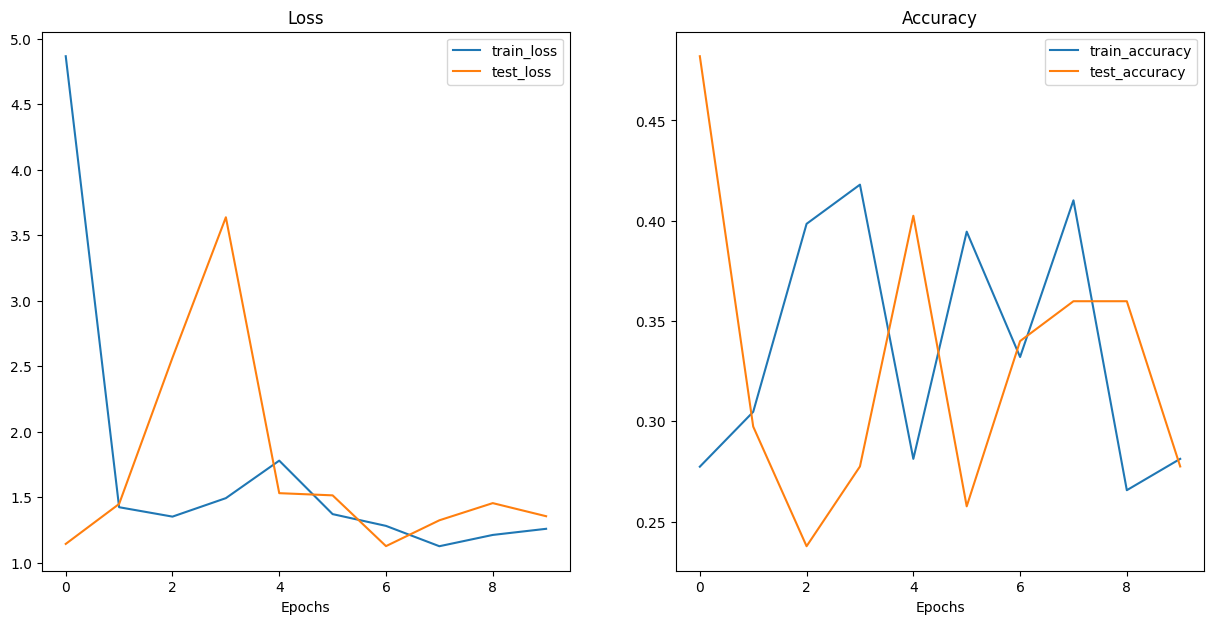

In [48]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Using a pretrained ViT model

In [49]:
import torch, torchvision

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [52]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(
    weights=pretrained_vit_weights
).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(
    in_features=768,
    out_features=len(class_names)
).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/balakrishnan/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [53]:
summary(
    model=pretrained_vit,
    input_size=(32, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [54]:
from helper_functions import download_data

image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination='pizza_steak_sushi'
)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [55]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [56]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [57]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names \
    = data_setup.create_dataloaders(
        train_dir=train_dir,
        test_dir=test_dir,
        transform=pretrained_vit_transforms,
        batch_size=32
    )

In [58]:
from going_modular import engine
optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=1e-3
)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5210 | test_acc: 0.8968
Epoch: 2 | train_loss: 0.3467 | train_acc: 0.9414 | test_loss: 0.2671 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.2308 | train_acc: 0.9492 | test_loss: 0.2084 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.1544 | train_acc: 0.9648 | test_loss: 0.2274 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.1329 | train_acc: 0.9648 | test_loss: 0.1601 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.1136 | train_acc: 0.9766 | test_loss: 0.1526 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.1466 | train_acc: 0.9766 | test_loss: 0.1624 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0837 | train_acc: 0.9805 | test_loss: 0.1650 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0837 | train_acc: 0.9805 | test_loss: 0.1538 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.0687 | train_acc: 0.9883 | test_loss: 0.2205 | test_acc: 0.9176


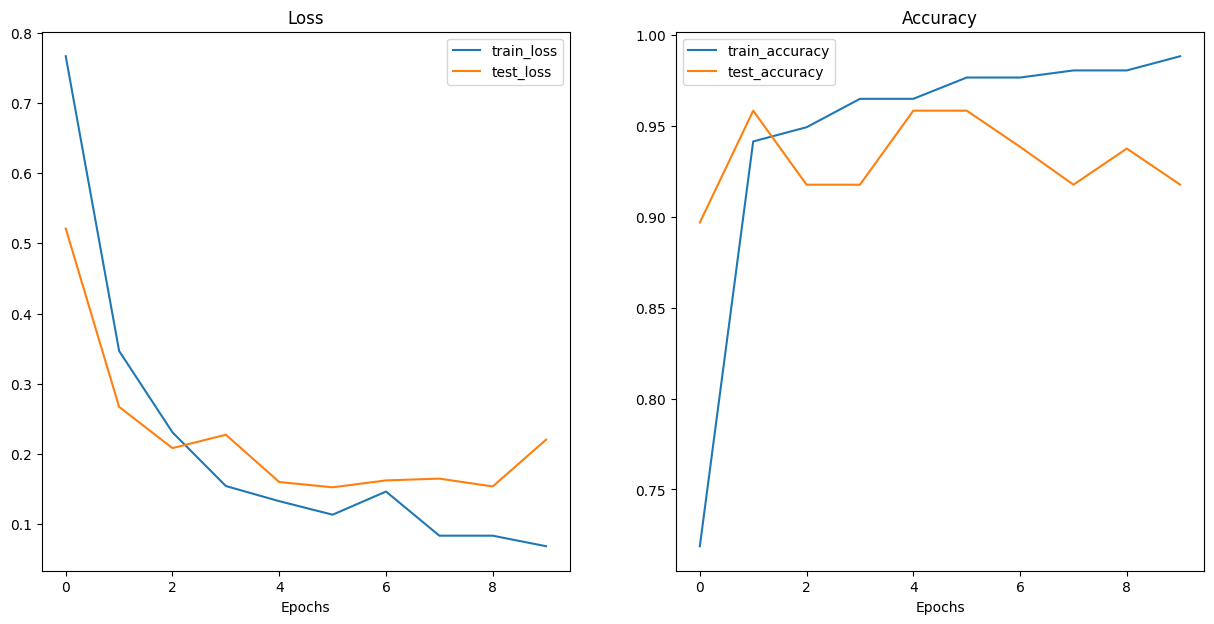

In [59]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

## Save model

In [60]:
from going_modular import utils

utils.save_model(
    model=pretrained_vit,
    target_dir='models',
    model_name='08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
)

[INFO] Saving model to:  models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [61]:
from pathlib import Path

pretrained_vit_model_size = Path(
    'models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
).stat().st_size // (1024**2)
print(pretrained_vit_model_size, 'MB')

327 MB


## Predicting on custom image

In [67]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
    plt.axis(False)

04-pizza-dad.jpeg already exists, skipping download.


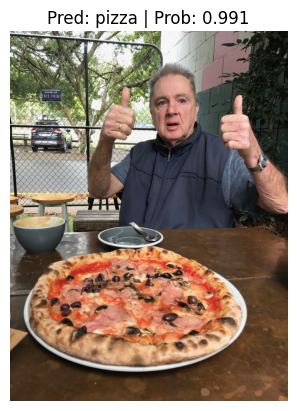

In [68]:
import requests

custom_image_path = Path('04-pizza-dad.jpeg')

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f'Downloading {custom_image_path}...')
        f.write(request.content)
else:
    print(custom_image_path, 'already exists, skipping download.')

pred_and_plot_image(
    model=pretrained_vit,
    image_path=custom_image_path,
    class_names=class_names
)